In [82]:
!pip install ta
!pip install yfinance

In [83]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import ta
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

In [84]:
np.random.seed(42)
tf.random.set_seed(42)

Setup of stocks and dates remains same for all the codes

In [85]:
tickers = ["AAPL", "MSFT", "GOOG", "^NSEI"]
 # correct NSE Nifty 50 ticker

start_date = "2015-01-01"
end_date = "2025-01-01"


To create Sequences of 21

In [86]:
def create_seq(df, seq_len=21, target_col='Close'):
    values = df.values
    target = df[target_col].values  # target by name
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)


I have Kept the model as a seperate function, To modularize it if required we can easily replace LSTM with any other model

In [87]:
def build_lstm(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(50, return_sequences=True),   # first LSTM returns sequences
        Dropout(0.2),
        LSTM(50, return_sequences=False),  # second LSTM outputs last hidden state
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [88]:
def gann_angle_features(df, lookback=100):
    df = df.copy()
    closes = df['Close'].values
    n = len(df)

    ga_up_1x1, ga_up_1x2, ga_up_2x1 = [], [], []
    ga_down_1x1, ga_down_1x2, ga_down_2x1 = [], [], []

    for i in range(n):
        if i < lookback:
            ga_up_1x1.append(np.nan); ga_up_1x2.append(np.nan); ga_up_2x1.append(np.nan)
            ga_down_1x1.append(np.nan); ga_down_1x2.append(np.nan); ga_down_2x1.append(np.nan)
        else:
            # Lookback window
            window = closes[i-lookback:i]

            ref_low_idx = np.argmin(window)
            ref_low_price = window[ref_low_idx]
            days_from_low = lookback - ref_low_idx

            ref_high_idx = np.argmax(window)
            ref_high_price = window[ref_high_idx]
            days_from_high = lookback - ref_high_idx

            # Up angles (from swing low)
            ga_up_1x1.append(closes[i] - (ref_low_price + 1.0*days_from_low))
            ga_up_1x2.append(closes[i] - (ref_low_price + 0.5*days_from_low))
            ga_up_2x1.append(closes[i] - (ref_low_price + 2.0*days_from_low))

            # Down angles (from swing high)
            ga_down_1x1.append(closes[i] - (ref_high_price - 1.0*days_from_high))
            ga_down_1x2.append(closes[i] - (ref_high_price - 0.5*days_from_high))
            ga_down_2x1.append(closes[i] - (ref_high_price - 2.0*days_from_high))

    # Add to df
    df['GA_up_1x1'] = ga_up_1x1
    df['GA_up_1x2'] = ga_up_1x2
    df['GA_up_2x1'] = ga_up_2x1
    df['GA_down_1x1'] = ga_down_1x1
    df['GA_down_1x2'] = ga_down_1x2
    df['GA_down_2x1'] = ga_down_2x1

    return df.dropna()



Run function which will run for all different features

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261049  24.729272  23.821673  24.718176  212818400
2015-01-05  23.577576  24.110152  23.391175  24.030265  257142000
2015-01-06  23.579788  23.839418  23.218079  23.641922  263188400
2015-01-07  23.910433  24.010290  23.677430  23.788384  160423600
2015-01-08  24.829132  24.886828  24.121249  24.238861  237458000
Datasets: Train: 1676, Val: 359, Test: 360
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
AAPL → RMSE: 17.7424, MAE: 14.3148, MAPE: 0.0673, R2: 0.4850


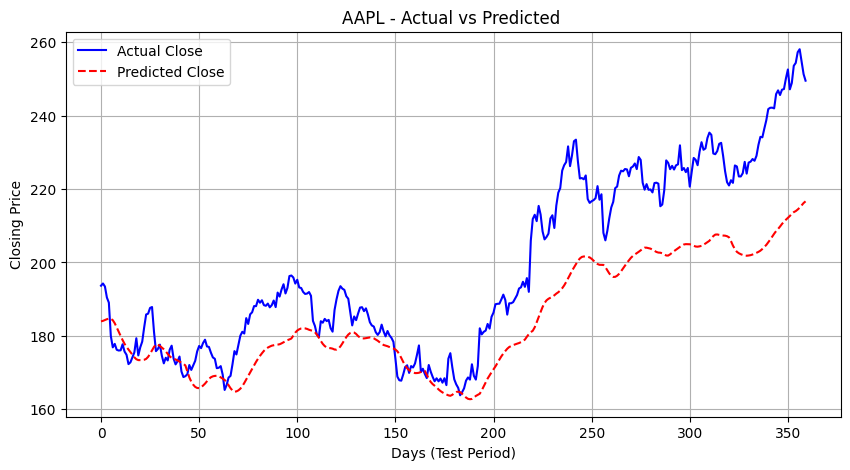

Price           Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2015-01-02  39.933048  40.496688  39.745170  39.847650  27913900
2015-01-05  39.565849  39.907448  39.497528  39.600007  39673900
2015-01-06  38.985111  39.924510  38.891171  39.608531  36447900
2015-01-07  39.480438  39.676858  38.848480  39.266938  29114100
2015-01-08  40.641869  40.778508  39.898889  39.924508  29645200
Datasets: Train: 1676, Val: 359, Test: 360
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
MSFT → RMSE: 38.1951, MAE: 33.6485, MAPE: 0.0826, R2: 0.1204


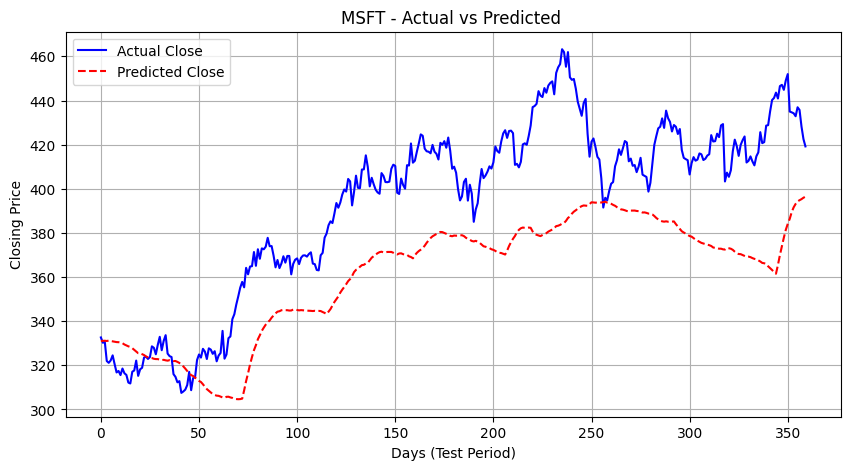

Price           Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                            
2015-01-02  26.014023  26.334236  25.978830  26.222210  28951268
2015-01-05  25.471743  25.990229  25.431593  25.937190  41196796
2015-01-06  24.881382  25.585999  24.836276  25.527755  57998800
2015-01-07  24.838753  25.143301  24.766878  25.131206  41301082
2015-01-08  24.917072  24.956727  24.338112  24.684596  67071641
Datasets: Train: 1676, Val: 359, Test: 360
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
GOOG → RMSE: 6.9869, MAE: 5.3808, MAPE: 0.0336, R2: 0.8687


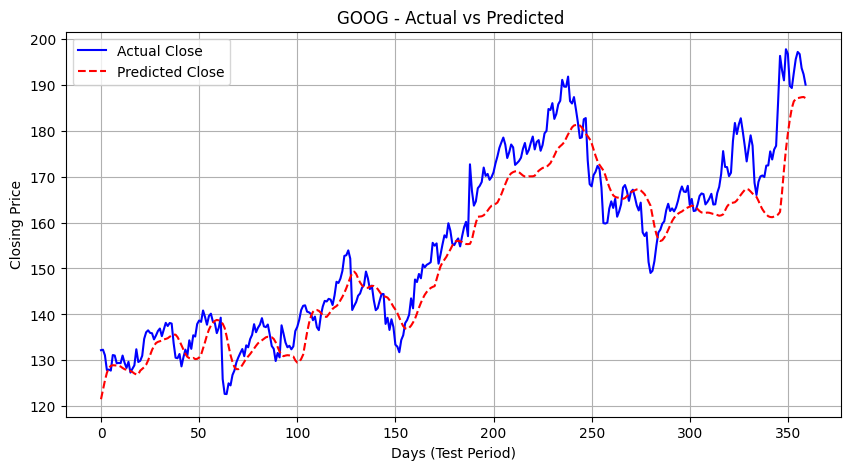

Price             Close         High          Low         Open  Volume
Ticker            ^NSEI        ^NSEI        ^NSEI        ^NSEI   ^NSEI
Date                                                                  
2015-01-02  8395.450195  8410.599609  8288.700195  8288.700195  101900
2015-01-05  8378.400391  8445.599609  8363.900391  8407.950195  118200
2015-01-06  8127.350098  8327.849609  8111.350098  8325.299805  172800
2015-01-07  8102.100098  8151.200195  8065.450195  8118.649902  164100
2015-01-08  8234.599609  8243.500000  8167.299805  8191.399902  143800
Datasets: Train: 1636, Val: 351, Test: 351
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
^NSEI → RMSE: 1171.2271, MAE: 997.0497, MAPE: 0.0427, R2: 0.6602


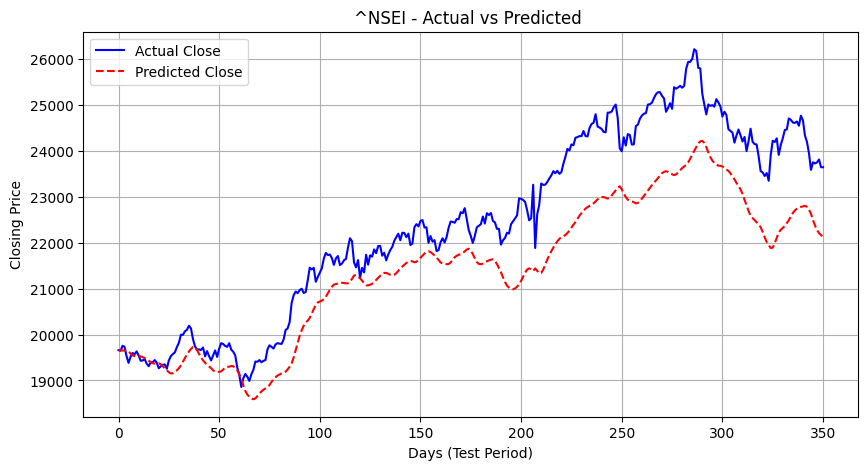

In [89]:
    for ticker in tickers:
      df = yf.download(ticker, start=start_date, end=end_date, progress=False)
      print(df.head())
      df = df[['Open', 'High', 'Low', 'Close']].round(2).dropna()
      df = gann_angle_features(df)
      df = df.astype(float)
      scaler_X = MinMaxScaler()
      scaled_features = scaler_X.fit_transform(df)
      scaler_y = MinMaxScaler()
      scaled_close = scaler_y.fit_transform(df[['Close']])
      df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
      X, y = create_seq(df_scaled)
      # After creating X, y
      n = len(X)
      train_end = int(n * 0.7)    # First 70% = training
      val_end   = int(n * 0.85)   # Next 15% = validation
                                  # Last 15% = test
      #chornological splitting of the data
      X_train, y_train = X[:train_end], y[:train_end]
      X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
      X_test, y_test   = X[val_end:], y[val_end:]
      print(f"Datasets: Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
      model = build_lstm((21, X.shape[2]))
      early_stop = EarlyStopping(
          monitor='val_loss',
          patience=8,
          mode='min',
          restore_best_weights=True
      )

      history = model.fit(
          X_train, y_train,
          validation_data=(X_val, y_val),
          epochs= 50,
          batch_size= 32,
          shuffle=False,
          callbacks=[early_stop],
          verbose=0
      )
      pred_scaled = model.predict(X_test).ravel()
      pred = scaler_y.inverse_transform(pred_scaled.reshape(-1,1)).ravel()
      y_test_real = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()
      rmse = math.sqrt(mean_squared_error(y_test_real, pred))
      mae = mean_absolute_error(y_test_real, pred)
      mape = mean_absolute_percentage_error(y_test_real, pred)
      r2 = r2_score(y_test_real, pred)
      print(f"{ticker} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}")

      plt.figure(figsize=(10,5))
      plt.plot(y_test_real, label="Actual Close", color='blue')
      plt.plot(pred, label="Predicted Close", color='red', linestyle='--')
      plt.title(f"{ticker} - Actual vs Predicted ")
      plt.xlabel("Days (Test Period)")
      plt.ylabel("Closing Price")
      plt.legend()
      plt.grid(True)
      plt.show()